In [1]:
library(tidyverse)
library(fitdistrplus)
library(scales)
library(lmtest)
library(car)
library(AER)
library(tseries)
library(gvlma)
getwd()
data <- read.csv("Social Media Polarity and attension seeking/Data/_Summary_Classified_Simple_Sum.csv")
data <- data.frame(data)

breaks_log10 <- function(x) {
  low <- floor(log10(min(x)))
  high <- ceiling(log10(max(x)))

  10^(seq.int(low, high))
}

outliersd <- 1.96

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: survival


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

[1] "/Users/kevin/Desktop/My Research"

In [2]:
save_plot <- function(plot, set_width = 8, set_height = 6){
    plot_name <- deparse(substitute(plot))
    ggsave(plot = plot,filename = paste(plot_name,"png",sep = "."), path = "Social Media Polarity and attension seeking/Report/Image",width = set_width,height = set_height,dpi = 300)
}

In [3]:
data <- data %>% mutate(prop = neg_count/(pos_count+neg_count+neutral_count)) %>% mutate(total_comment = pos_count+neg_count+neutral_count)


data$Political <- as.factor(data$Political)
data <- data %>% mutate(category = recode_factor(Political, 
                                        "0" = "Others", 
                                        "1" = "Political"))
data$prop <- jitter(data$prop,factor = 0.00001)

data_numeric <- data %>% dplyr::select(where(is.numeric))
data_numeric <- data_numeric %>% mutate(neg_count = log(neg_count),pos_count=log(1+pos_count),neutral_count = log(1+neutral_count),total_comment = log(total_comment), views = log(views),neg_score = log(neg_score), pos_score = log(1+pos_score), neutral_score = log(1+neutral_score))

summary(data)
# Calculate means and standard deviations for numeric variables
means <- colMeans(data_numeric, na.rm = TRUE)
sds <- apply(data_numeric, 2, sd, na.rm = TRUE)

thresholds <- means + outliersd * sds
data <- data %>% 
  mutate(impulse_dummy = ifelse(
    log(views) > thresholds['views'] | 
    log(neg_count) > thresholds['neg_count'] | 
    log(neg_score) > thresholds['neg_score'] | 
    log(total_comment) > thresholds['total_comment'], 
    1, 
    0
  ))
thresholds <- means - outliersd * sds
data <- data %>% 
  mutate(impulse_dummy = ifelse(
    log(views) < thresholds['views'] | 
    log(neg_count) < thresholds['neg_count'] | 
    log(neg_score) < thresholds['neg_score'] | 
    log(total_comment) < thresholds['total_comment'], 
    1, 
    0
  ))

# Filter the data to exclude rows with impulse dummy equal to 1
data <- data %>%
  filter(impulse_dummy == 0)
summary(data)

mean_value <- mean(data$ln_total_comment)  
sd_value <- sd(data$ln_total_comment)  


print(summary(data$views))

     vid               title           Political total_comment   
 Length:393         Length:393         0:123     Min.   :  24.0  
 Class :character   Class :character   1:270     1st Qu.: 260.0  
 Mode  :character   Mode  :character             Median : 520.0  
                                                 Mean   : 927.8  
                                                 3rd Qu.:1069.0  
                                                 Max.   :9686.0  
   publish              views           neg_count        pos_count      
 Length:393         Min.   :  11091   Min.   :  12.0   Min.   :   0.00  
 Class :character   1st Qu.:  82887   1st Qu.: 144.0   1st Qu.:  15.00  
 Mode  :character   Median : 174553   Median : 283.0   Median :  30.00  
                    Mean   : 369792   Mean   : 529.9   Mean   :  69.64  
                    3rd Qu.: 370739   3rd Qu.: 604.0   3rd Qu.:  66.00  
                    Max.   :9832056   Max.   :5960.0   Max.   :1301.00  
 neutral_count      pos_sco

     vid               title           Political total_comment   
 Length:371         Length:371         0:110     Min.   :  84.0  
 Class :character   Class :character   1:261     1st Qu.: 295.0  
 Mode  :character   Mode  :character             Median : 551.0  
                                                 Mean   : 977.9  
                                                 3rd Qu.:1148.5  
                                                 Max.   :9686.0  
   publish              views           neg_count        pos_count      
 Length:371         Min.   :  23209   Min.   :  41.0   Min.   :   3.00  
 Class :character   1st Qu.:  97314   1st Qu.: 162.0   1st Qu.:  16.00  
 Mode  :character   Median : 179809   Median : 307.0   Median :  31.00  
                    Mean   : 389010   Mean   : 559.3   Mean   :  73.03  
                    3rd Qu.: 381052   3rd Qu.: 623.0   3rd Qu.:  71.00  
                    Max.   :9832056   Max.   :5960.0   Max.   :1301.00  
 neutral_count      pos_sco

Warning message in mean.default(data$ln_total_comment):
"argument is not numeric or logical: returning NA"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23209   97314  179809  389010  381052 9832056 


In [4]:
Views_Plot <- ggplot(data, aes(x = log(views))) +
  geom_histogram(aes(y= stat(density)),fill = "skyblue", color = "black", binwidth = 0.25) +
  geom_density(alpha = 0.5) +
  labs(x = "Amount of views(log scale)",
       y = "Density") +
  theme_minimal()
  theme_minimal()

save_plot(Views_Plot)

List of 97
 $ line                      :List of 6
  ..$ colour       : chr "black"
  ..$ linewidth    : num 0.5
  ..$ linetype     : num 1
  ..$ lineend      : chr "butt"
  ..$ arrow        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_line" "element"
 $ rect                      :List of 5
  ..$ fill         : chr "white"
  ..$ colour       : chr "black"
  ..$ linewidth    : num 0.5
  ..$ linetype     : num 1
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_rect" "element"
 $ text                      :List of 11
  ..$ family       : chr ""
  ..$ face         : chr "plain"
  ..$ colour       : chr "black"
  ..$ size         : num 11
  ..$ hjust        : num 0.5
  ..$ vjust        : num 0.5
  ..$ angle        : num 0
  ..$ lineheight   : num 0.9
  ..$ margin       : 'margin' num [1:4] 0points 0points 0points 0points
  .. ..- attr(*, "unit")= int 8
  ..$ debug        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr

Warning message:
"`stat(density)` was deprecated in ggplot2 3.4.0.
i Please use `after_stat(density)` instead."


In [5]:
Comments_Plot <- ggplot(data, aes(x = log(total_comment))) +
  geom_histogram(aes(y= stat(density)),fill = "skyblue", color = "black", binwidth = 0.25) +
  geom_density(alpha = 0.5) +
  labs(x = "Amount of Comments(log scale)",
       y = "Density") +
  theme_minimal()

save_plot(Comments_Plot)

In [6]:
# Jarque-Bera test for log of views
view_test <- jarque.bera.test(log(data$views))
print(view_test)

# Jarque-Bera test for log of total comments
comment_test <- jarque.bera.test(log(data$total_comment))
print(comment_test)

# Jarque-Bera test for log of negative comments
neg_comment_test <- jarque.bera.test(log(data$neg_count))
print(neg_comment_test)


	Jarque Bera Test

data:  log(data$views)
X-squared = 23.463, df = 2, p-value = 8.038e-06


	Jarque Bera Test

data:  log(data$total_comment)
X-squared = 10.727, df = 2, p-value = 0.004684


	Jarque Bera Test

data:  log(data$neg_count)
X-squared = 9.8688, df = 2, p-value = 0.007195



In [7]:
data_ctrl <- data
print(summary(data_ctrl))
print(str(data_ctrl))

     vid               title           Political total_comment   
 Length:371         Length:371         0:110     Min.   :  84.0  
 Class :character   Class :character   1:261     1st Qu.: 295.0  
 Mode  :character   Mode  :character             Median : 551.0  
                                                 Mean   : 977.9  
                                                 3rd Qu.:1148.5  
                                                 Max.   :9686.0  
   publish              views           neg_count        pos_count      
 Length:371         Min.   :  23209   Min.   :  41.0   Min.   :   3.00  
 Class :character   1st Qu.:  97314   1st Qu.: 162.0   1st Qu.:  16.00  
 Mode  :character   Median : 179809   Median : 307.0   Median :  31.00  
                    Mean   : 389010   Mean   : 559.3   Mean   :  73.03  
                    3rd Qu.: 381052   3rd Qu.: 623.0   3rd Qu.:  71.00  
                    Max.   :9832056   Max.   :5960.0   Max.   :1301.00  
 neutral_count      pos_sco

NULL


	Shapiro-Wilk normality test

data:  log(data$views)
W = 0.9771, p-value = 1.298e-05



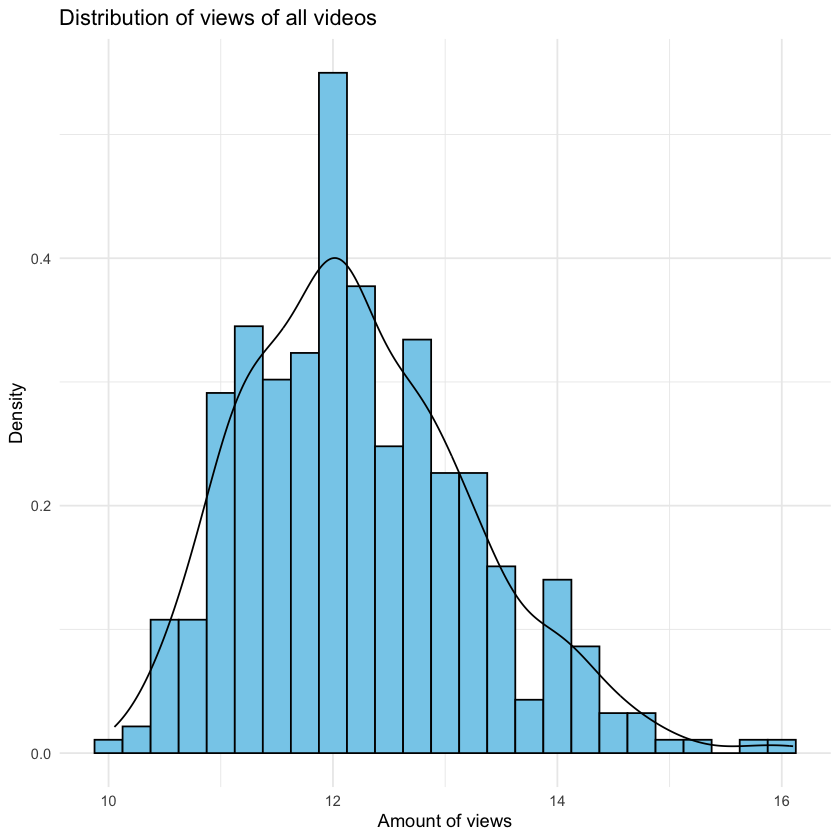

In [8]:
ggplot(data_ctrl, aes(x = log(views))) +
  geom_histogram(aes(y= stat(density)),fill = "skyblue", color = "black", binwidth = 0.25) +
  geom_density(alpha = 0.5) +
  labs(title = "Distribution of views of all videos",
       x = "Amount of views",
       y = "Density") +
  theme_minimal()
  labs(x = "Prop", y = "Probability Density") +
  theme_minimal()
#Normality test of log view:
shapiro_test_result <- shapiro.test(log(data$views))
print(shapiro_test_result)

In [9]:
data_ctrl <- data
# KS-test for beta-dist of views
beta_fit <- fitdist(data_ctrl$prop, "beta")

ks_test <- ks.test(data_ctrl$prop, "pbeta", 
                   shape1 = beta_fit$estimate[1],
                   shape2 = beta_fit$estimate[2])

print(ks_test)
print("\n")
print(beta_fit)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_ctrl$prop
D = 0.049222, p-value = 0.3299
alternative hypothesis: two-sided

[1] "\n"
Fitting of the distribution ' beta ' by maximum likelihood 
Parameters:
        estimate Std. Error
shape1 12.531338  0.9127709
shape2  9.645117  0.6983401


NULL

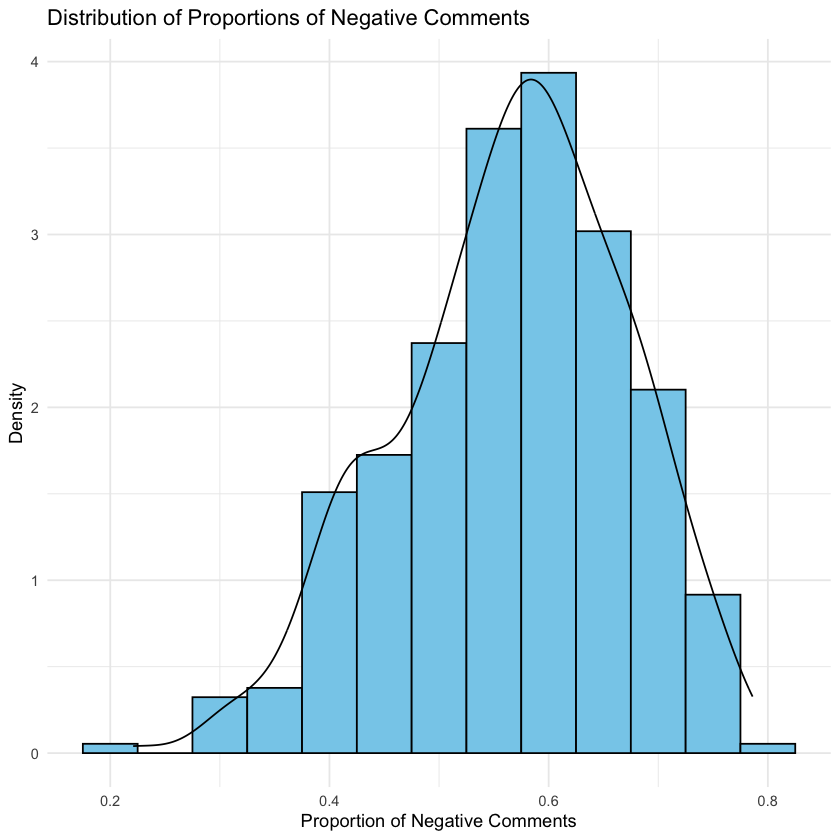

In [10]:
ggplot(data_ctrl, aes(x = prop)) +
  geom_histogram(aes(y=stat(density)),fill = "skyblue", color = "black", binwidth = 0.05) +
  geom_density(alpha = 0.5) +
  labs(title = "Distribution of Proportions of Negative Comments",
       x = "Proportion of Negative Comments",
       y = "Density") +
  theme_minimal()
  labs(x = "Prop", y = "Probability Density") +
  theme_minimal()

In [11]:
t.test(total_comment ~ category, data = data)


	Welch Two Sample t-test

data:  total_comment by category
t = 0.59529, df = 147.54, p-value = 0.5526
alternative hypothesis: true difference in means between group Others and group Political is not equal to 0
95 percent confidence interval:
 -234.3871  436.4725
sample estimates:
   mean in group Others mean in group Political 
              1048.9545                947.9119 


In [12]:
data_pol <- data_ctrl %>% filter(Political == 1)
data_non <- data_ctrl %>% filter(Political == 0)
summary(data_pol$prop)
summary(data_non$prop)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3051  0.5249  0.5887  0.5813  0.6515  0.7861 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2209  0.4633  0.5302  0.5282  0.6076  0.7423 

#### Test for Normality

#### Test for beta distribution(Due to the *Proportional* nature of this value)

In [13]:
pol_fit <- fitdist(data_pol$prop, "beta")

ks_test <- ks.test(data_pol$prop, "pbeta", 
                   shape1 = pol_fit$estimate[1],
                   shape2 = pol_fit$estimate[2])

print(ks_test)
print("\n")
print(pol_fit)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_pol$prop
D = 0.056929, p-value = 0.3661
alternative hypothesis: two-sided

[1] "\n"
Fitting of the distribution ' beta ' by maximum likelihood 
Parameters:
       estimate Std. Error
shape1 14.10039  1.2261048
shape2 10.17141  0.8783947


In [14]:
pol_fit <- fitdist(data_non$prop, "beta")

ks_test <- ks.test(data_non$prop, "pbeta", 
                   shape1 = pol_fit$estimate[1],
                   shape2 = pol_fit$estimate[2])

print(ks_test)
print("\n")
print(pol_fit)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_non$prop
D = 0.047652, p-value = 0.9641
alternative hypothesis: two-sided

[1] "\n"
Fitting of the distribution ' beta ' by maximum likelihood 
Parameters:
       estimate Std. Error
shape1 11.48006   1.532852
shape2 10.27522   1.368464


In [15]:
non_fit <- fitdist(data_non$prop, "beta")

ks_test <- ks.test(data_non$prop, "pbeta", 
                   shape1 = non_fit$estimate[1],
                   shape2 = non_fit$estimate[2])

print(ks_test)
print("\n")
print(non_fit)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_non$prop
D = 0.047652, p-value = 0.9641
alternative hypothesis: two-sided

[1] "\n"
Fitting of the distribution ' beta ' by maximum likelihood 
Parameters:
       estimate Std. Error
shape1 11.48006   1.532852
shape2 10.27522   1.368464


In [16]:
two_sample <- ks.test(x=data_pol$prop,y=data_non$prop, alternative = c("less"),"pbeta")
print(two_sample)

Warning message in ks.test.default(x = data_pol$prop, y = data_non$prop, alternative = c("less"), :
"Parameter(s)  ignored"



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  data_pol$prop and data_non$prop
D^- = 0.28199, p-value = 4.518e-06
alternative hypothesis: the CDF of x lies below that of y



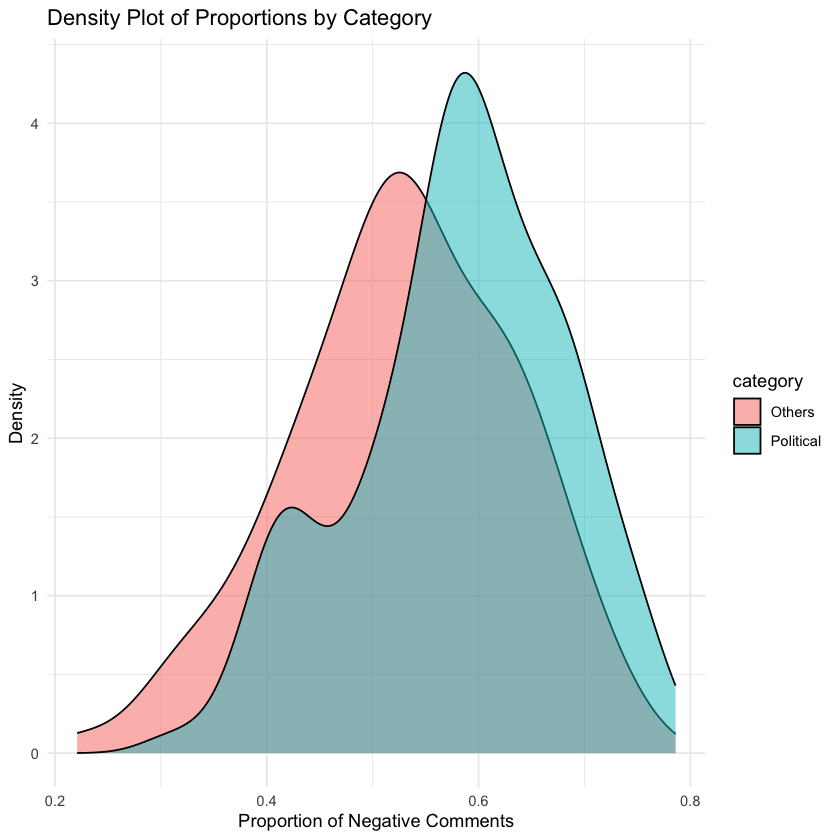

In [17]:
# Plot ECDFs
ECDF_neg_prop <- ggplot(data_ctrl, aes(x = prop, color = category)) +
  stat_ecdf(geom = "step") +
  labs(x = "Proportion of Negative Comments",
       y = "ECDF") +
  theme_minimal()

save_plot(ECDF_neg_prop)

# Plot density plots
ggplot(data_ctrl, aes(x = prop, fill = category)) +
  geom_density(alpha = 0.5) +
  labs(title = "Density Plot of Proportions by Category",
       x = "Proportion of Negative Comments",
       y = "Density") +
  theme_minimal()



In [18]:
#Comparing views and total comments
ks.test(data$total_comment,data_non$total_comment)

ks.test(data_pol$views,data_non$views)


#### Hypothesis 1:
$$ln(comment_{neg})=\alpha+\beta_{1}ln(comment)+\beta_{2}category$$

In [19]:
print(head(data))

          vid
1 oV4EHkr4410
2 MDlM5wDt1E8
3 A5klkoFRg20
4 3uZA2oxxNdE
5 EIVsqtJiOAU
6 3K8R5aHR2L8
                                                                                     title
1                            Speaker welcomes MPs back to their 'place of work' - BBC News
2                                                    MPs back Brexit deal delay - BBC News
3                                 Robert Mueller: Charging Trump was not option - BBC News
4                               Trump impeachment: House unveils formal charges - BBC News
5 UNLV shooting: Las Vegas police say suspect in university shooting found dead | BBC News
6                                  Scores feared drowned in shipwreck off Libya - BBC News
  Political total_comment                   publish  views neg_count pos_count
1         1           236 2019-09-25 10:43:42+00:00 165638       124        26
2         1           266 2019-10-19 14:08:45+00:00 125434       148        23
3         1           426 20


Call:
lm(formula = neg_count ~ total_comment + category + views, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81048 -0.07734  0.03783  0.11218  0.33499 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.37833    0.12352   3.063  0.00235 ** 
total_comment      1.15114    0.01715  67.139  < 2e-16 ***
categoryPolitical  0.04422    0.02032   2.176  0.03021 *  
views             -0.16062    0.01586 -10.126  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1715 on 367 degrees of freedom
Multiple R-squared:  0.969,	Adjusted R-squared:  0.9687 
F-statistic:  3819 on 3 and 367 DF,  p-value: < 2.2e-16


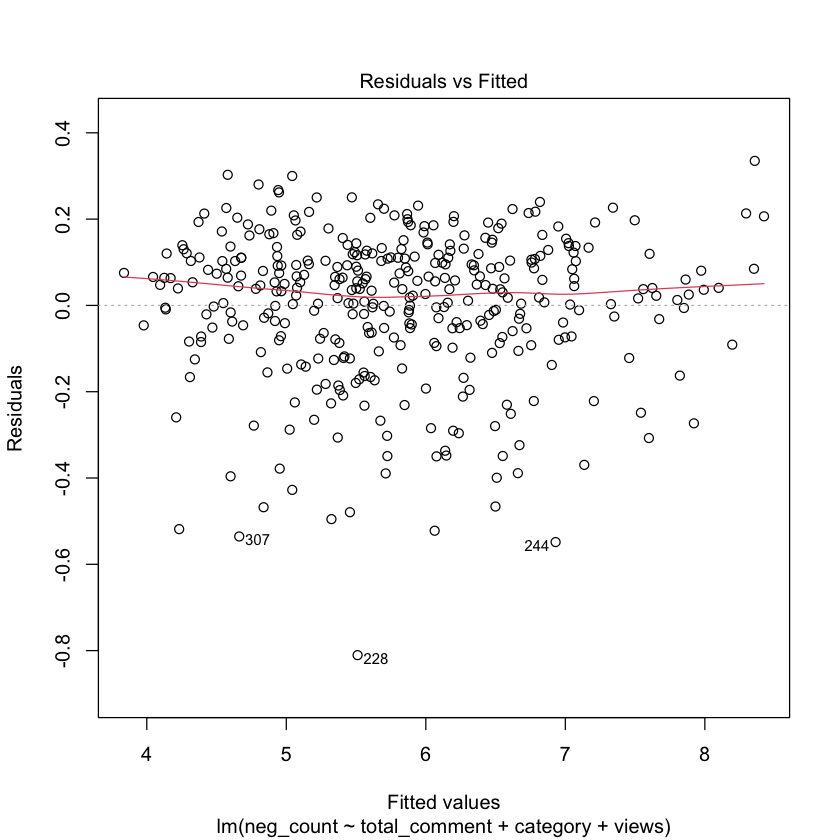

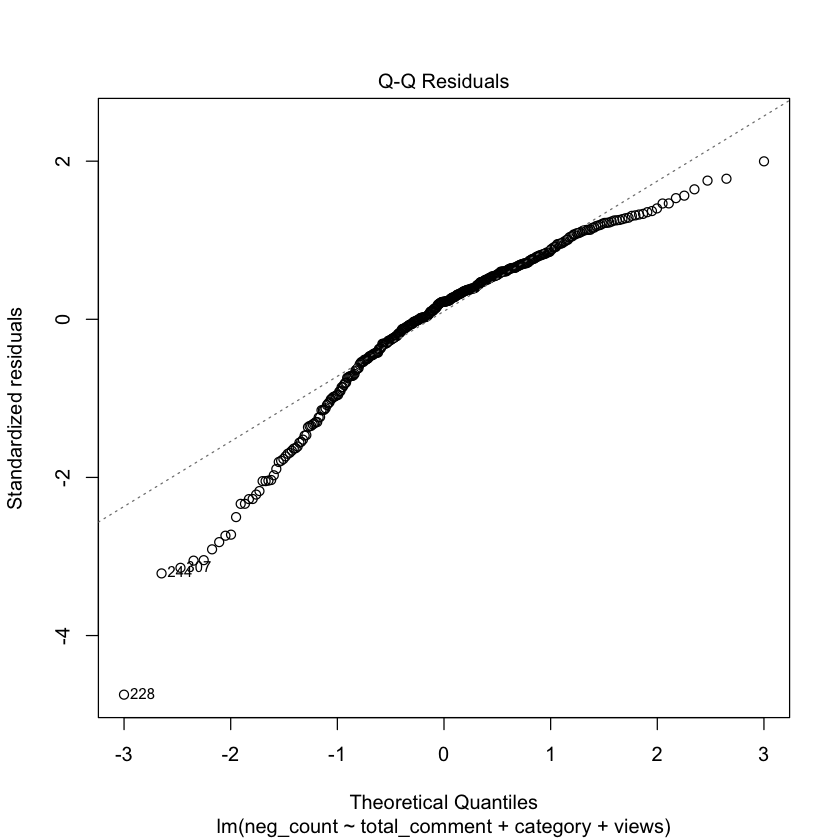

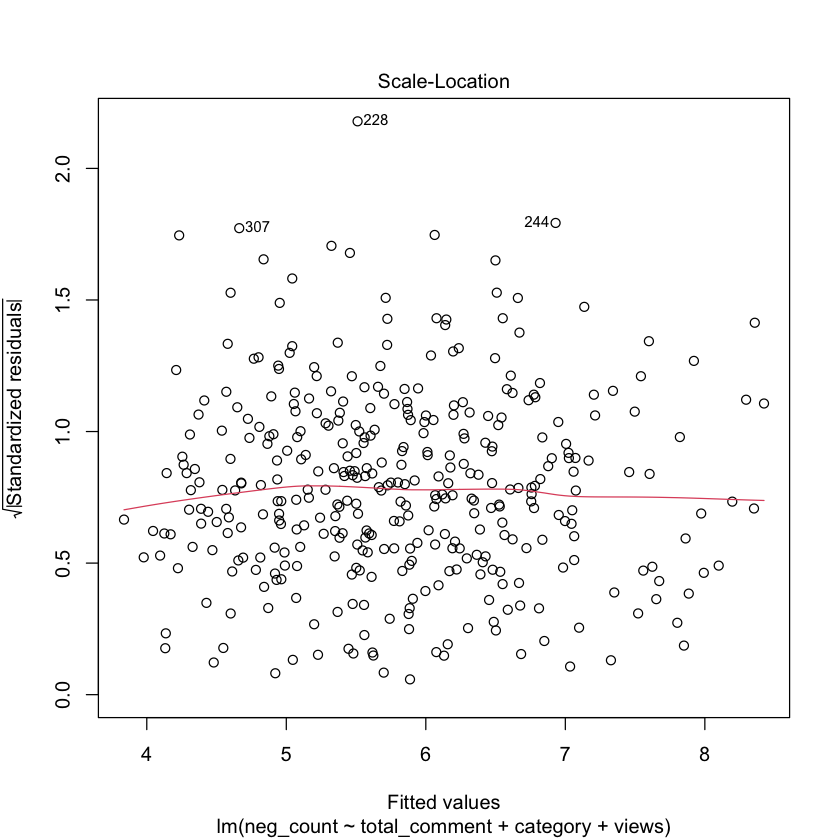

`geom_smooth()` using formula = 'y ~ x'



	Shapiro-Wilk normality test

data:  residuals
W = 0.92852, p-value = 2.508e-12


	RESET test

data:  model
RESET = 1.5716, df1 = 2, df2 = 365, p-value = 0.2091


	studentized Breusch-Pagan test

data:  model
BP = 0.30953, df = 2, p-value = 0.8566



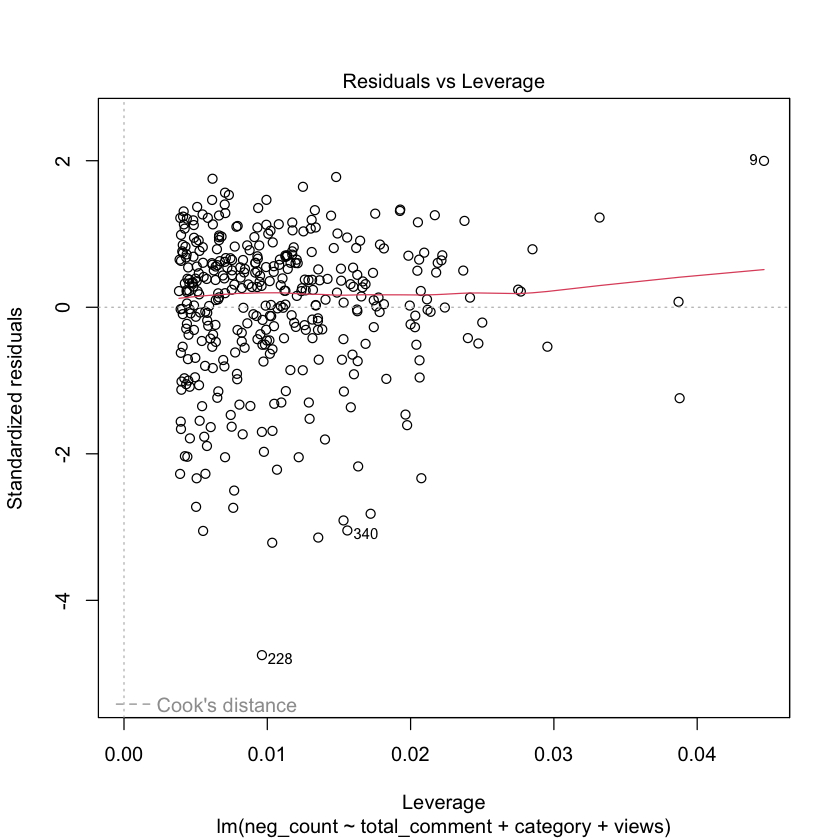

In [20]:
data <- data %>% mutate(neg_count = log(neg_count),pos_count=log(1+pos_count),neutral_count = log(1+neutral_count),total_comment = log(total_comment), views = log(views),neg_score = log(neg_score), pos_score = log(1+pos_score), neutral_score = log(1+neutral_score))
model <- lm(neg_count ~ total_comment + category + views, data = data)  
summary(model) 
plot(model)
H1_Regression_Neg <- ggplot(data, aes(x = total_comment, y = neg_count, color = factor(category))) +  
  geom_point(alpha = 0.1)+
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5,level = 0.95) +  
  labs(x = "total comments(log scale)",  
       y = "negative comments(log scale)",  
       color = "Cateogory of news") +  
  theme_minimal()

save_plot(H1_Regression_Neg)

residuals <- model$residuals
shapiro_test <- shapiro.test(residuals)
print(shapiro_test)
print(resettest(model))

bp_test <- bptest(model, ~ fitted(model) + I(fitted(model)^2))
print(bp_test)


Call:
lm(formula = pos_count ~ total_comment + category, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.81843 -0.52316 -0.06712  0.44352  2.02257 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.79316    0.26559  -6.752 5.71e-11 ***
total_comment      0.85529    0.04051  21.111  < 2e-16 ***
categoryPolitical -0.10489    0.08332  -1.259    0.209    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7319 on 368 degrees of freedom
Multiple R-squared:  0.5478,	Adjusted R-squared:  0.5453 
F-statistic: 222.9 on 2 and 368 DF,  p-value: < 2.2e-16


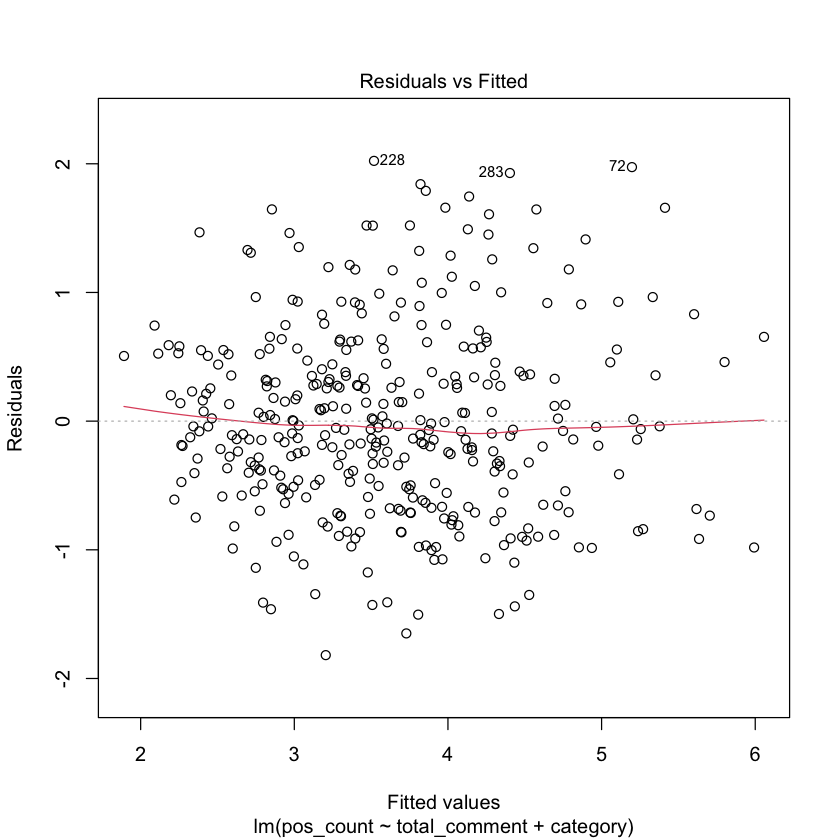

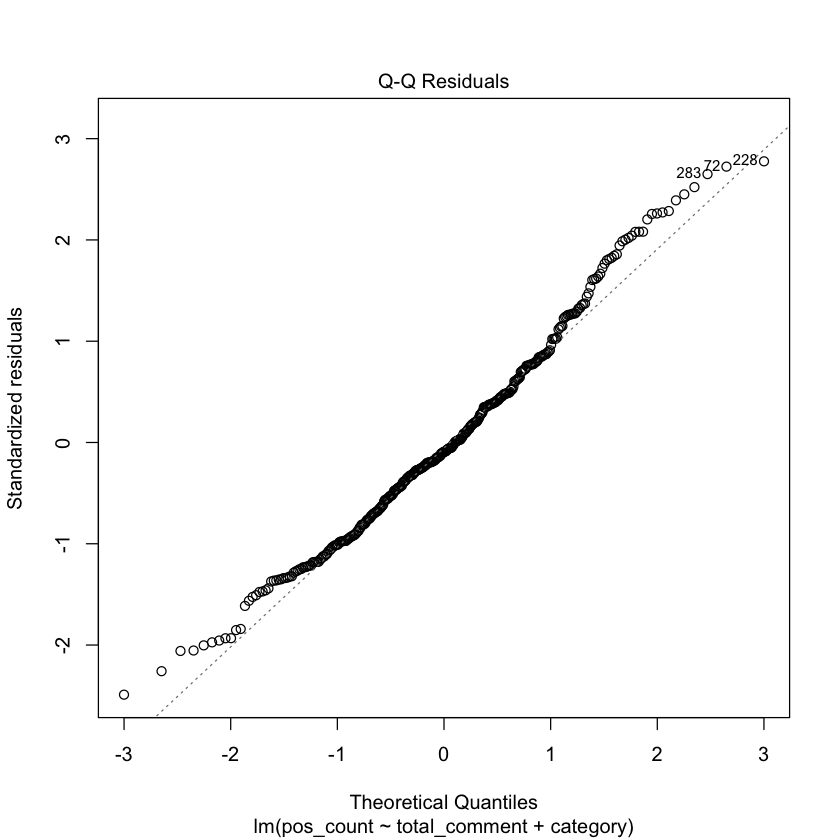

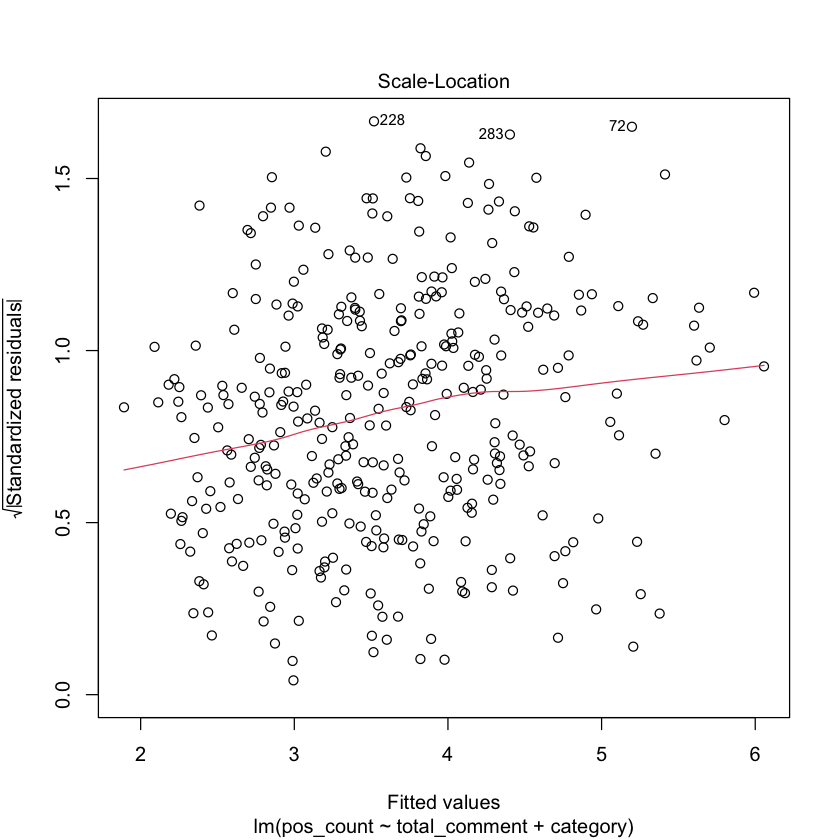

`geom_smooth()` using formula = 'y ~ x'



	Shapiro-Wilk normality test

data:  residuals
W = 0.98608, p-value = 0.001238


	RESET test

data:  model
RESET = 0.58088, df1 = 2, df2 = 366, p-value = 0.5599


	studentized Breusch-Pagan test

data:  model
BP = 12.287, df = 2, p-value = 0.002148



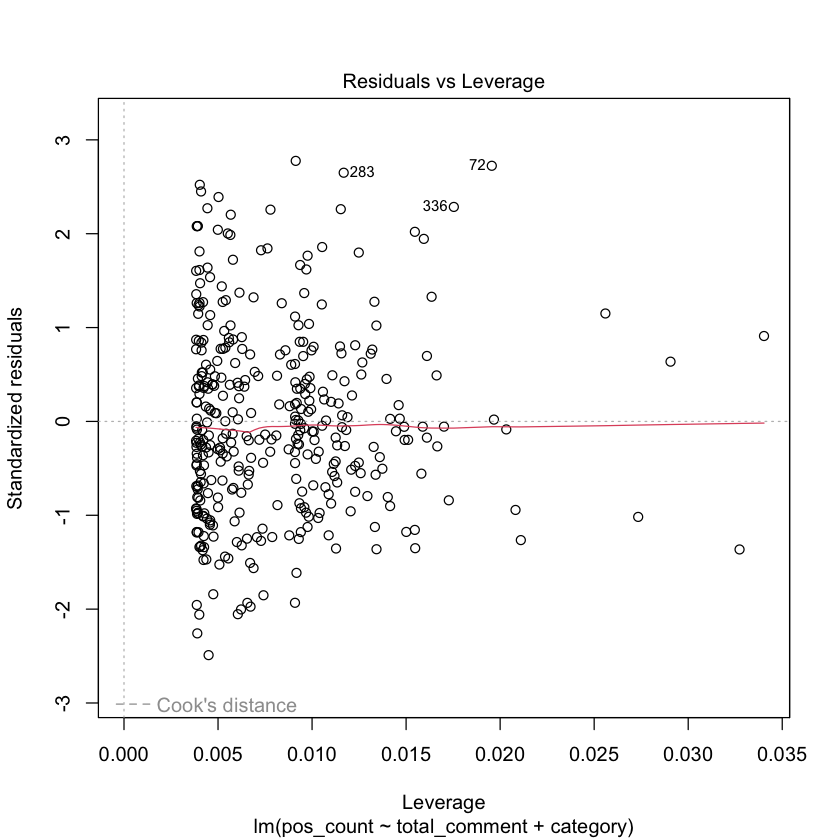

In [21]:
model <- lm(pos_count ~ total_comment + category, data = data)  
summary(model) 
plot(model)
H1_Regression_Pos <- ggplot(data, aes(x = total_comment, y = pos_count, color = factor(category))) +  
  geom_point(alpha = 0.1)+
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5,level = 0.95) +  
  labs(x = "total comments(log scale)",  
       y = "positive comments(log scale)",  
       color = "Cateogory of news") +  
  theme_minimal()

save_plot(H1_Regression_Pos)

residuals <- model$residuals
shapiro_test <- shapiro.test(residuals)
print(shapiro_test)
print(resettest(model))

bp_test <- bptest(model, ~ fitted(model) + I(fitted(model)^2))
print(bp_test)


Call:
lm(formula = neutral_count ~ total_comment + category, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.73594 -0.14339  0.01255  0.13650  0.47759 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.90403    0.07465 -12.111  < 2e-16 ***
total_comment      0.99045    0.01139  86.986  < 2e-16 ***
categoryPolitical -0.12100    0.02342  -5.167  3.9e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2057 on 368 degrees of freedom
Multiple R-squared:  0.9536,	Adjusted R-squared:  0.9534 
F-statistic:  3783 on 2 and 368 DF,  p-value: < 2.2e-16


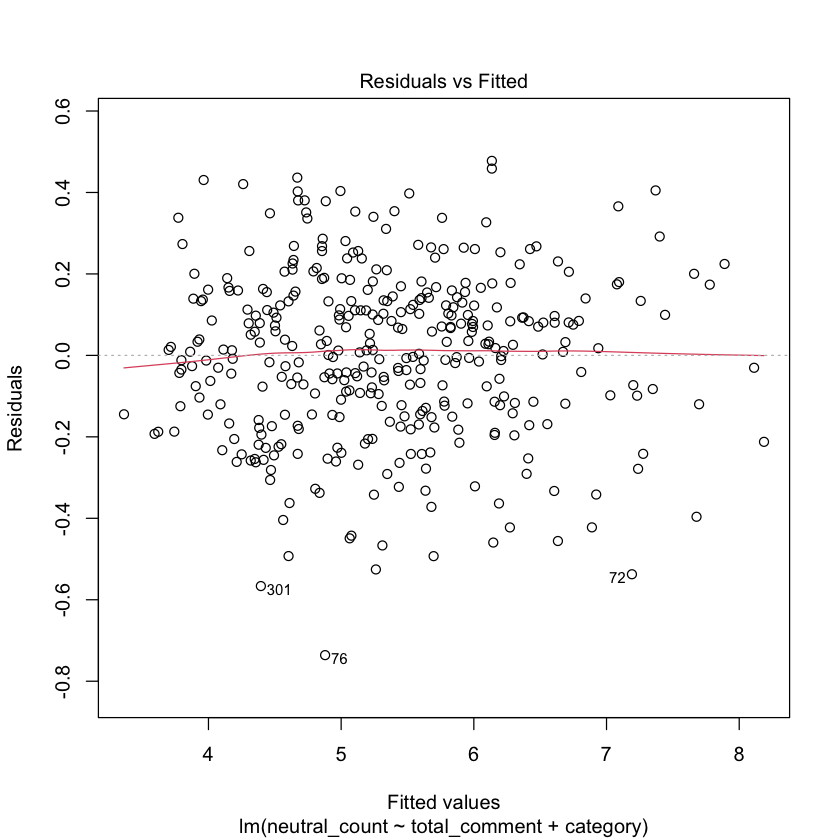

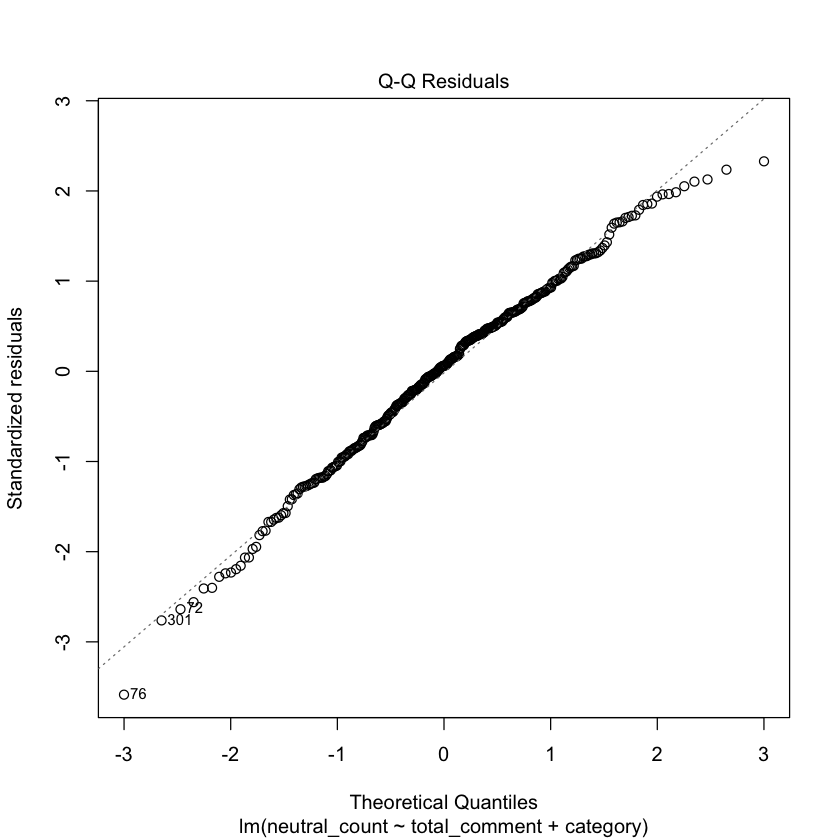

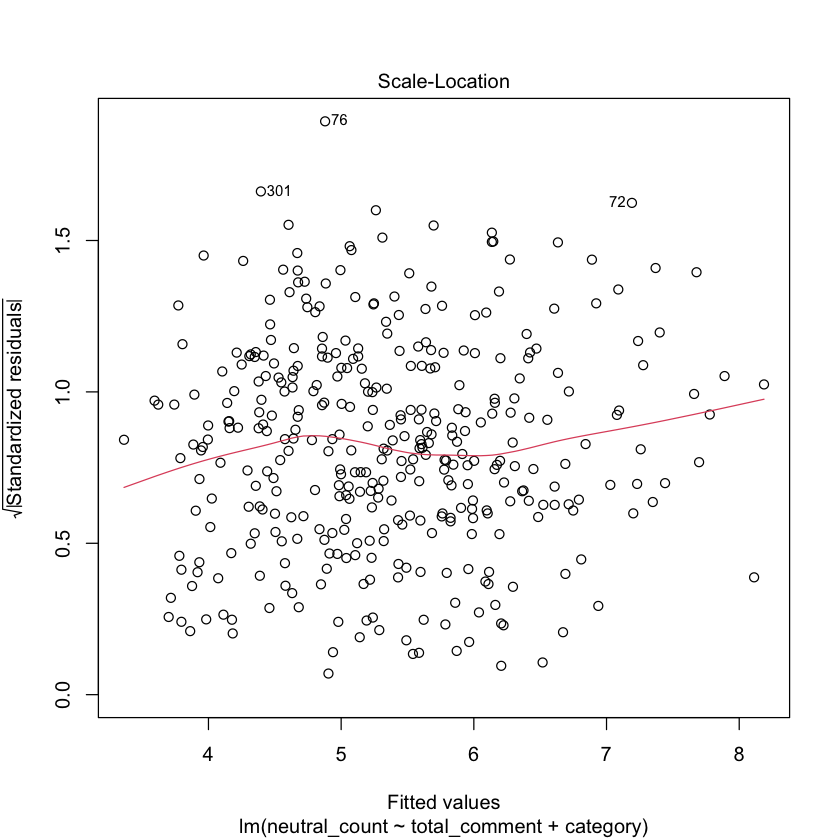

`geom_smooth()` using formula = 'y ~ x'



	Shapiro-Wilk normality test

data:  residuals
W = 0.99207, p-value = 0.04541


	RESET test

data:  model
RESET = 0.12143, df1 = 2, df2 = 366, p-value = 0.8857


	studentized Breusch-Pagan test

data:  model
BP = 0.28218, df = 2, p-value = 0.8684



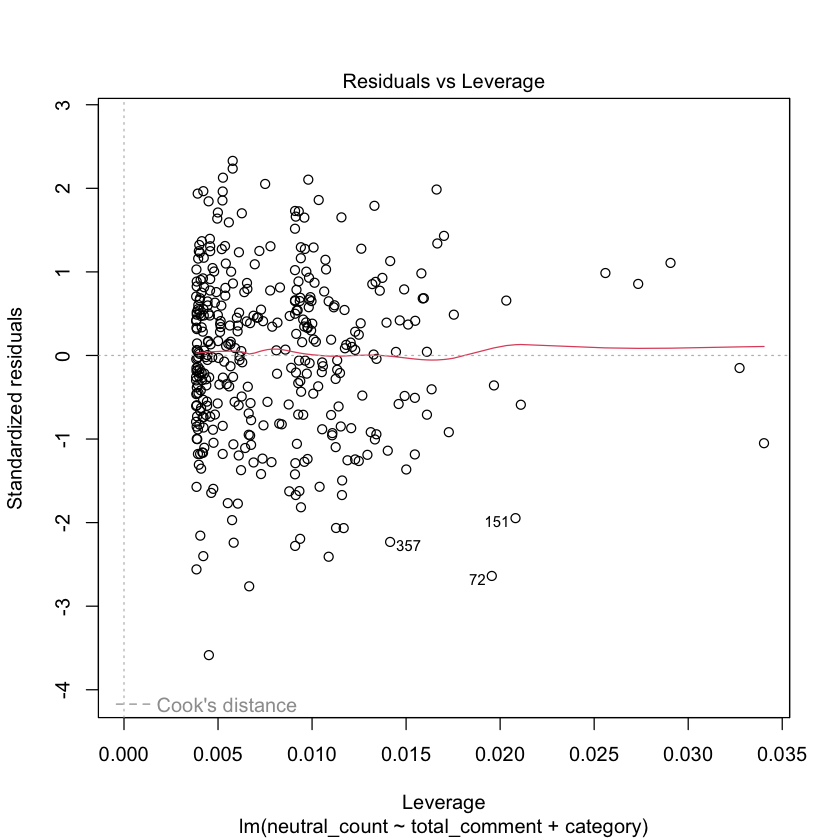

In [22]:
model <- lm(neutral_count ~ total_comment + category, data = data)  
summary(model) 
plot(model)
H1_Regression_Neu <- ggplot(data, aes(x = total_comment, y = neutral_count, color = factor(category))) +  
  geom_point(alpha = 0.1)+
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5,level = 0.95) +  
  labs(x = "total comments(log scale)",  
       y = "neutral comments(log scale)",  
       color = "Cateogory of news") +  
  theme_minimal()

save_plot(H1_Regression_Neu)

residuals <- model$residuals
shapiro_test <- shapiro.test(residuals)
print(shapiro_test)
print(resettest(model))

bp_test <- bptest(model, ~ fitted(model) + I(fitted(model)^2))
print(bp_test)

## Hypothesis 2

## Two stage least square

In [37]:
library(mediation)
data <- read.csv("Social Media Polarity and attension seeking/Data/_Summary_Classified_Simple_Sum.csv")

data$Political <- as.factor(data$Political)
data <- data %>% mutate(category = recode_factor(Political, "0" = "Others", "1" = "Political"))

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loading required package: mvtnorm

Warning message:
"package 'mvtnorm' was built under R version 4.3.3"
Warning message in check_dep_version():
"ABI version mismatch: 
lme4 was built with Matrix ABI version 1
Current Matrix ABI version is 0
Please re-install lme4 from source or restore original 'Matrix' package"
mediation: Causal Mediation Analysis
Version: 4.5.0




### 2SLS:


In [38]:
data <- data %>% mutate(neg_count = log(neg_count),pos_count=log(1+pos_count),neutral_count = log(1+neutral_count),total_comment = log(total_comment), views = log(views),neg_score = log(neg_score), pos_score = log(1+pos_score), neutral_score = log(1+neutral_score))

# Ensure to only calculate means and standard deviations for numeric columns
data_numeric <- data %>% dplyr::select(where(is.numeric))
summary(data)
# Calculate means and standard deviations for numeric variables
means <- colMeans(data_numeric, na.rm = TRUE)
sds <- apply(data_numeric, 2, sd, na.rm = TRUE)

thresholds <- means + outliersd * sds
data <- data %>% 
  mutate(impulse_dummy = ifelse(
    views > thresholds['views'] | 
    neg_count > thresholds['neg_count'] | 
    neg_score > thresholds['neg_score'] | 
    total_comment > thresholds['total_comment'], 
    1, 
    0
  ))
thresholds <- means - outliersd * sds
data <- data %>% 
  mutate(impulse_dummy = ifelse(
    views < thresholds['views'] | 
    neg_count < thresholds['neg_count'] | 
    neg_score < thresholds['neg_score'] | 
    total_comment < thresholds['total_comment'], 
    1, 
    0
  ))

# Filter the data to exclude rows with impulse dummy equal to 1
data <- data %>%
  filter(impulse_dummy == 0)
summary(data)

     vid               title           Political total_comment  
 Length:393         Length:393         0:123     Min.   :3.178  
 Class :character   Class :character   1:270     1st Qu.:5.561  
 Mode  :character   Mode  :character             Median :6.254  
                                                 Mean   :6.283  
                                                 3rd Qu.:6.974  
                                                 Max.   :9.178  
   publish              views          neg_count       pos_count    
 Length:393         Min.   : 9.314   Min.   :2.485   Min.   :0.000  
 Class :character   1st Qu.:11.325   1st Qu.:4.970   1st Qu.:2.773  
 Mode  :character   Median :12.070   Median :5.645   Median :3.434  
                    Mean   :12.144   Mean   :5.679   Mean   :3.517  
                    3rd Qu.:12.823   3rd Qu.:6.404   3rd Qu.:4.205  
                    Max.   :16.101   Max.   :8.693   Max.   :7.172  
 neutral_count     pos_score        neg_score      neutral_sco

     vid               title           Political total_comment  
 Length:371         Length:371         0:110     Min.   :4.431  
 Class :character   Class :character   1:261     1st Qu.:5.687  
 Mode  :character   Mode  :character             Median :6.312  
                                                 Mean   :6.401  
                                                 3rd Qu.:7.046  
                                                 Max.   :9.178  
   publish              views         neg_count       pos_count    
 Length:371         Min.   :10.05   Min.   :3.714   Min.   :1.386  
 Class :character   1st Qu.:11.49   1st Qu.:5.088   1st Qu.:2.833  
 Mode  :character   Median :12.10   Median :5.727   Median :3.466  
                    Mean   :12.24   Mean   :5.812   Mean   :3.608  
                    3rd Qu.:12.85   3rd Qu.:6.435   3rd Qu.:4.277  
                    Max.   :16.10   Max.   :8.693   Max.   :7.172  
 neutral_count     pos_score        neg_score      neutral_score   
 

In [39]:
array_1 = rep(1,length(data$neg_count))
vif_result <- lm(neg_count ~ views, data = data)
print(summary(vif_result))


vif_result <- vif(lm(array_1 ~ neg_count + views + total_comment, data = data))
print(vif_result)
#transforming df


Call:
lm(formula = neg_count ~ views, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0829 -0.4277  0.0026  0.4464  1.9170 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.82148    0.40543  -6.959 1.57e-11 ***
views        0.70559    0.03302  21.369  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6491 on 369 degrees of freedom
Multiple R-squared:  0.5531,	Adjusted R-squared:  0.5519 
F-statistic: 456.6 on 1 and 369 DF,  p-value: < 2.2e-16



Warning message in summary.lm(object, ...):
"essentially perfect fit: summary may be unreliable"


    neg_count         views total_comment 
    31.805891      4.074296     43.366500 



	RESET test

data:  first_stage
RESET = 1.5716, df1 = 2, df2 = 365, p-value = 0.2091


	Jarque Bera Test

data:  residuals(first_stage)
X-squared = 128.98, df = 2, p-value < 2.2e-16


	studentized Breusch-Pagan test

data:  first_stage
BP = 0.30953, df = 2, p-value = 0.8566




Call:
lm(formula = neg_count ~ total_comment + category + views, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81048 -0.07734  0.03783  0.11218  0.33499 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.37833    0.12352   3.063  0.00235 ** 
total_comment      1.15114    0.01715  67.139  < 2e-16 ***
categoryPolitical  0.04422    0.02032   2.176  0.03021 *  
views             -0.16062    0.01586 -10.126  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1715 on 367 degrees of freedom
Multiple R-squared:  0.969,	Adjusted R-squared:  0.9687 
F-statistic:  3819 on 3 and 367 DF,  p-value: < 2.2e-16


Running nonparametric bootstrap





Causal Mediation Analysis 

Nonparametric Bootstrap Confidence Intervals with the Percentile Method

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME              1.579        1.198         1.96  <2e-16 ***
ADE              -0.348       -0.747         0.05   0.095 .  
Total Effect      1.231        1.102         1.35  <2e-16 ***
Prop. Mediated    1.282        0.957         1.62  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Sample Size Used: 371 


Simulations: 2000 


Running nonparametric bootstrap





Causal Mediation Analysis 

Nonparametric Bootstrap Confidence Intervals with the Percentile Method

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             1.2078       0.8777         1.51  <2e-16 ***
ADE             -0.0609      -0.3668         0.27    0.73    
Total Effect     1.1469       1.0871         1.20  <2e-16 ***
Prop. Mediated   1.0531       0.7680         1.32  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Sample Size Used: 371 


Simulations: 2000 



	Jarque Bera Test

data:  residuals(med_model)
X-squared = 61.45, df = 2, p-value = 4.53e-14


	Jarque Bera Test

data:  residuals(out_model)
X-squared = 27.454, df = 2, p-value = 1.093e-06



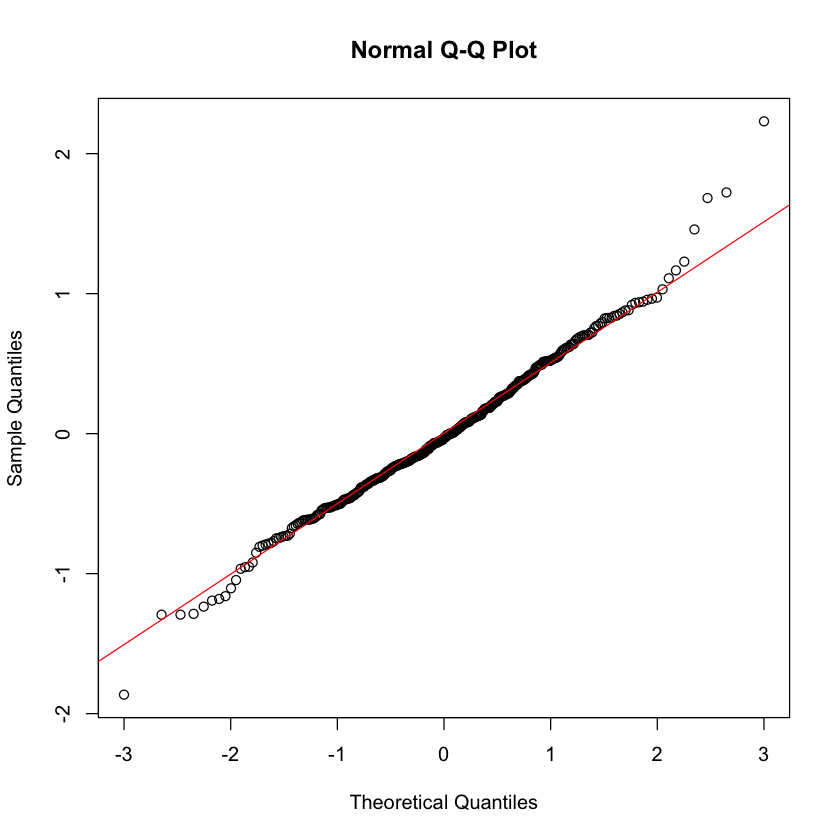


Call:
ivreg(formula = neg_score ~ neg_count + category + views | total_comment + 
    category + views, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.86457 -0.33620 -0.03187  0.34282  2.23076 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.33197    0.37621   0.882   0.3781    
neg_count          1.06973    0.04628  23.117  < 2e-16 ***
categoryPolitical -0.26065    0.06371  -4.092 5.27e-05 ***
views              0.07792    0.04329   1.800   0.0727 .  

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 367  4507.699  <2e-16 ***
Wu-Hausman         1 366     3.231  0.0731 .  
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.533 on 367 degrees of freedom
Multiple R-Squared: 0.8119,	Adjusted R-squared: 0.8104 
Wald test: 505.3 on 3 and 367 DF,  p-value: < 2.2e-16 



	Jarque Bera Test

data:  residuals(second_stage)
X-squared = 18.244, df = 2, p-value = 0.0001092


	RESET test

data:  second_stage
RESET = 0.25632, df1 = 2, df2 = 365, p-value = 0.774


	studentized Breusch-Pagan test

data:  second_stage
BP = 0.31475, df = 2, p-value = 0.8544



`geom_smooth()` using formula = 'y ~ x'


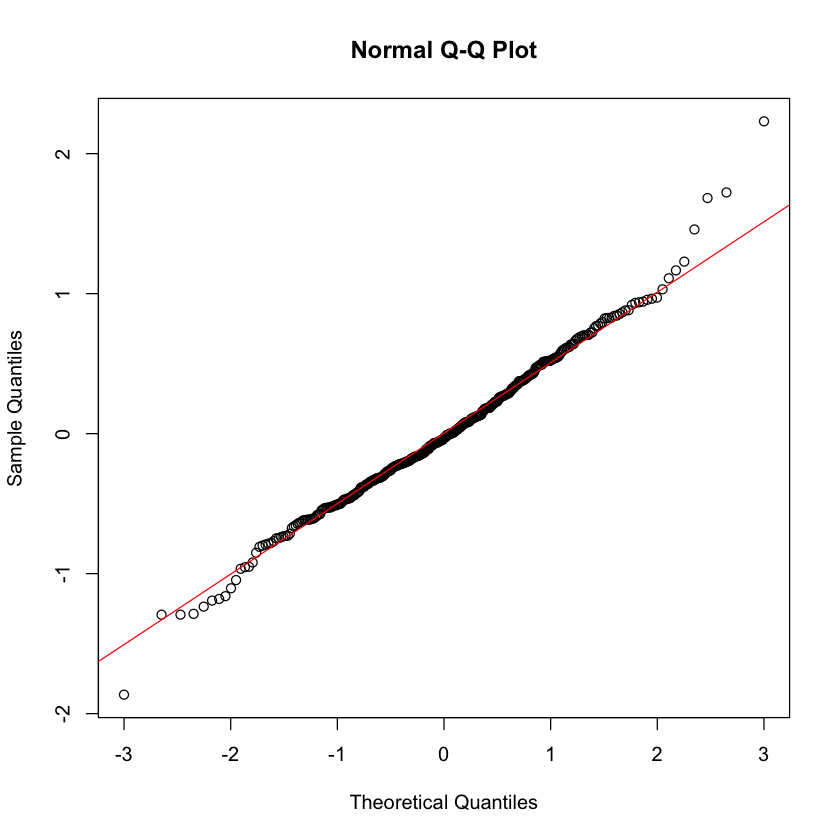

In [40]:
first_stage <- lm(neg_count ~ total_comment + category + views, data = data)
print(resettest(first_stage))
normal_test <- jarque.bera.test(residuals(first_stage))
print(normal_test)

bp_test <- bptest(first_stage, ~ fitted(first_stage) + I(fitted(first_stage)^2))
print(bp_test)


summary(first_stage,diagnostics = TRUE)



med_model <- lm(neg_count ~ total_comment + category + views, data = data)

# Fit the outcome model
out_model <- lm(neg_score ~ neg_count + total_comment + category + views, data = data)

# Perform mediation analysis
med_analysis <- mediate(med_model, out_model, treat = "total_comment", mediator = "neg_count",sims=2000,boot = TRUE)
summary(med_analysis)


med_model <- lm(neg_count ~ total_comment + category, data = data)

# Fit the outcome model
out_model <- lm(neg_score ~ neg_count + total_comment + category, data = data)

# Perform mediation analysis
med_analysis <- mediate(med_model, out_model, treat = "total_comment", mediator = "neg_count",sims=2000,boot = TRUE)
summary(med_analysis)

normal_test <- jarque.bera.test(residuals(med_model))
print(normal_test)
normal_test <- jarque.bera.test(residuals(out_model))
print(normal_test)

second_stage <- ivreg(neg_score ~ neg_count + category + views | total_comment + category + views, data = data)

fitted_values <- fitted(second_stage)
residuals_values <- residuals(second_stage)
qqnorm(residuals_values)
qqline(residuals_values, col = "red")

# Q-Q Plot
qqnorm(residuals_values)
qqline(residuals_values, col = "red")

summary(second_stage,diagnostics = TRUE)
normal_test <- jarque.bera.test(residuals(second_stage))
print(normal_test)
print(resettest(second_stage))

bp_test <- bptest(second_stage, ~ fitted(second_stage) + I(fitted(second_stage)^2))
print(bp_test)

# save_plot(H2_reg_neg_pred)
H2_reg_neg_comment <- ggplot(data, aes(x = predict(first_stage), y = predict(second_stage), color = category, group = category)) +
  geom_point(aes(y = neg_score), alpha = 0.5) +  # Scatter plot points
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5, level = 0.95) +  # Regression lines with confidence intervals
  labs(title = "2 Stage least square for negative comment likes",
       x = "Negative Count Prediction",
       y = "Negative Score") +
  theme_minimal()
save_plot(H2_reg_neg_comment)


	RESET test

data:  first_stage_pos
RESET = 0.4328, df1 = 2, df2 = 365, p-value = 0.649


	Jarque Bera Test

data:  residuals(first_stage_pos)
X-squared = 7.3543, df = 2, p-value = 0.02529


	studentized Breusch-Pagan test

data:  first_stage_pos
BP = 11.204, df = 2, p-value = 0.003691




Call:
lm(formula = pos_count ~ total_comment + category + views, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.11483 -0.47980 -0.09497  0.43370  2.01491 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -4.49715    0.50180  -8.962  < 2e-16 ***
total_comment      0.49345    0.06966   7.084 7.19e-12 ***
categoryPolitical  0.03800    0.08257   0.460    0.646    
views              0.40205    0.06444   6.239 1.22e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6969 on 367 degrees of freedom
Multiple R-squared:  0.5911,	Adjusted R-squared:  0.5878 
F-statistic: 176.9 on 3 and 367 DF,  p-value: < 2.2e-16



Call:
lm(formula = pos_score ~ pos_count + category + views + total_comment, 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.14662 -0.58854  0.01736  0.59264  2.36574 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.13242    0.77281  -0.171  0.86404    
pos_count          1.40890    0.07282  19.348  < 2e-16 ***
categoryPolitical -0.06447    0.11522  -0.560  0.57610    
views              0.26227    0.09455   2.774  0.00582 ** 
total_comment     -0.47923    0.10360  -4.626 5.19e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9722 on 366 degrees of freedom
Multiple R-squared:  0.6812,	Adjusted R-squared:  0.6778 
F-statistic: 195.5 on 4 and 366 DF,  p-value: < 2.2e-16



Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             0.6966       0.5068         0.89  <2e-16 ***
ADE             -0.4786      -0.7113        -0.24  <2e-16 ***
Total Effect     0.2179      -0.0715         0.51    0.15    
Prop. Mediated   2.8548     -20.5601        21.63    0.15    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Sample Size Used: 371 


Simulations: 1000 



	Jarque Bera Test

data:  residuals(med_model_pos)
X-squared = 7.3543, df = 2, p-value = 0.02529


	Jarque Bera Test

data:  residuals(out_model_pos)
X-squared = 0.82939, df = 2, p-value = 0.6605



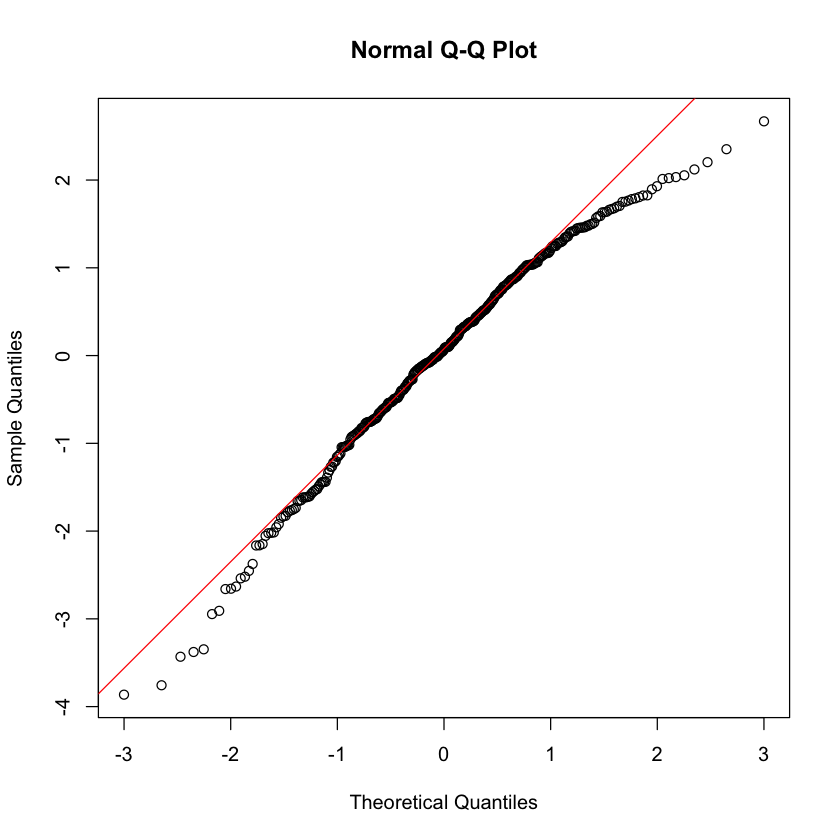


Call:
ivreg(formula = pos_score ~ pos_count + category + views | total_comment + 
    total_comment + category + views, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.86394 -0.74049  0.06782  0.89638  2.66911 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)       -4.49995    1.64773  -2.731  0.00662 **
pos_count          0.43772    0.23972   1.826  0.06866 . 
categoryPolitical -0.02757    0.14285  -0.193  0.84706   
views              0.65272    0.19705   3.312  0.00102 **

Diagnostic tests:
                 df1 df2 statistic  p-value    
Weak instruments   1 367     50.19 7.19e-12 ***
Wu-Hausman         1 366     21.40 5.19e-06 ***
Sargan             0  NA        NA       NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.183 on 367 degrees of freedom
Multiple R-Squared: 0.5263,	Adjusted R-squared: 0.5224 
Wald test: 91.73 on 3 and 367 DF,  p-value: < 2.2e-16 



	Jarque Bera Test

data:  residuals(second_stage_pos)
X-squared = 16.542, df = 2, p-value = 0.0002558


	RESET test

data:  second_stage_pos
RESET = 1.7957, df1 = 2, df2 = 365, p-value = 0.1675


	studentized Breusch-Pagan test

data:  second_stage_pos
BP = 1.8651, df = 2, p-value = 0.3936



`geom_smooth()` using formula = 'y ~ x'


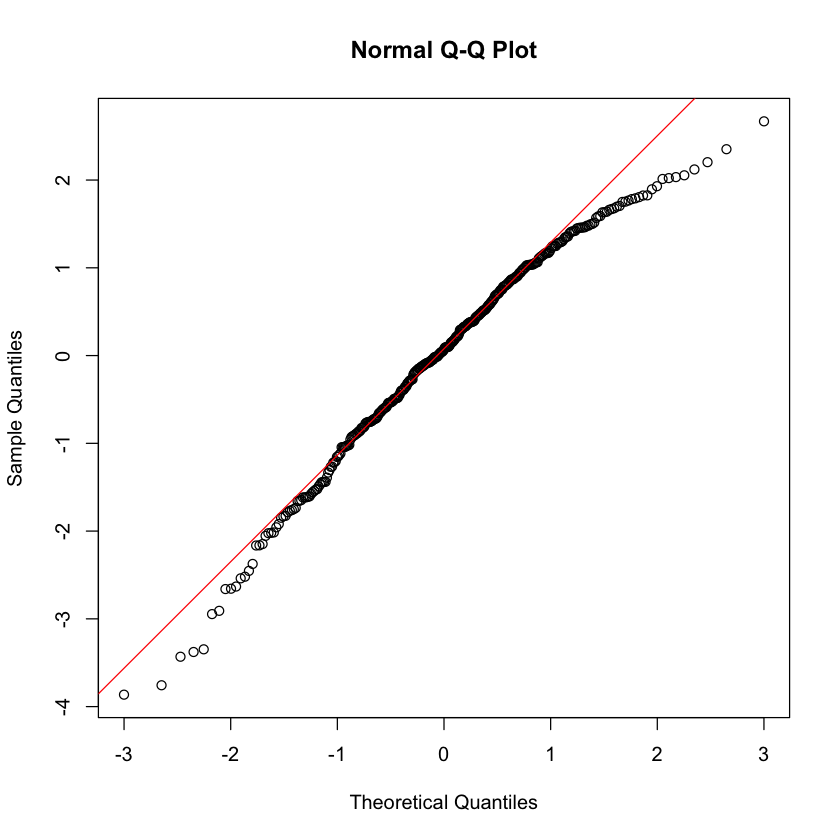

In [41]:
# First stage regression for Positive Count
first_stage_pos <- lm(pos_count ~ total_comment + category + views, data = data)
print(resettest(first_stage_pos))
normal_test_pos <- jarque.bera.test(residuals(first_stage_pos))
print(normal_test_pos)

bp_test_pos <- bptest(first_stage_pos, ~ fitted(first_stage_pos) + I(fitted(first_stage_pos)^2))
print(bp_test_pos)

summary(first_stage_pos, diagnostics = TRUE)

# Fit the mediation model for Positive Count
med_model_pos <- lm(pos_count ~ total_comment + category + views, data = data)

# Fit the outcome model for Positive Score
out_model_pos <- lm(pos_score ~ pos_count + category + views + total_comment, data = data)
summary(out_model_pos)

# Perform mediation analysis for Positive variables
med_analysis_pos <- mediate(med_model_pos, out_model_pos, treat = "total_comment", mediator = "pos_count", sims=1000, robustSE = TRUE)
summary(med_analysis_pos)

# Normality test for Positive Count model
normal_test_pos <- jarque.bera.test(residuals(med_model_pos))
print(normal_test_pos)

normal_test_pos_out <- jarque.bera.test(residuals(out_model_pos))
print(normal_test_pos_out)

# Second stage regression for Positive Score
second_stage_pos <- ivreg(pos_score ~ pos_count + category + views | total_comment + total_comment + category + views, data = data)

fitted_values_pos <- fitted(second_stage_pos)
residuals_values_pos <- residuals(second_stage_pos)
qqnorm(residuals_values_pos)
qqline(residuals_values_pos, col = "red")

# Q-Q Plot for Positive Score
qqnorm(residuals_values_pos)
qqline(residuals_values_pos, col = "red")

summary(second_stage_pos, diagnostics = TRUE)
normal_test_pos_second_stage <- jarque.bera.test(residuals(second_stage_pos))
print(normal_test_pos_second_stage)
print(resettest(second_stage_pos))

bp_test_pos_second_stage <- bptest(second_stage_pos, ~ fitted(second_stage_pos) + I(fitted(second_stage_pos)^2))
print(bp_test_pos_second_stage)

# Plot for Positive Comments
H2_reg_pos_comment <- ggplot(data, aes(x = predict(first_stage_pos), y = predict(second_stage_pos), color = category, group = category)) +
  geom_point(aes(y = pos_score), alpha = 0.5) +  # Scatter plot points
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE, linewidth = 0.5, level = 0.95) +  # Regression lines with confidence intervals
  labs(title = "2 Stage Least Squares for Positive Comment Likes",
       x = "Positive Count Prediction",
       y = "Positive Score") +
  theme_minimal()

# Save the plot for Positive Comments
save_plot(H2_reg_pos_comment)


	RESET test

data:  first_stage_neu
RESET = 0.52196, df1 = 2, df2 = 365, p-value = 0.5938


	Jarque Bera Test

data:  residuals(first_stage_neu)
X-squared = 4.7856, df = 2, p-value = 0.09137


	studentized Breusch-Pagan test

data:  first_stage_neu
BP = 2.0527, df = 2, p-value = 0.3583




Call:
lm(formula = neutral_count ~ total_comment + category + views, 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66705 -0.10658  0.00541  0.12300  0.52463 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.96362    0.13379 -14.677  < 2e-16 ***
total_comment      0.84866    0.01857  45.698  < 2e-16 ***
categoryPolitical -0.06501    0.02201  -2.953  0.00335 ** 
views              0.15755    0.01718   9.169  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1858 on 367 degrees of freedom
Multiple R-squared:  0.9623,	Adjusted R-squared:  0.962 
F-statistic:  3120 on 3 and 367 DF,  p-value: < 2.2e-16



Call:
lm(formula = neutral_score ~ neutral_count + category + views + 
    total_comment, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96749 -0.34592  0.04996  0.33635  2.34763 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.01845    0.49947   0.037    0.971    
neutral_count      1.09900    0.15469   7.104 6.35e-12 ***
categoryPolitical -0.02423    0.06601  -0.367    0.714    
views              0.07719    0.05645   1.367    0.172    
total_comment      0.02664    0.14235   0.187    0.852    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5506 on 366 degrees of freedom
Multiple R-squared:  0.8125,	Adjusted R-squared:  0.8105 
F-statistic: 396.6 on 4 and 366 DF,  p-value: < 2.2e-16



Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             0.9328       0.6666         1.18  <2e-16 ***
ADE              0.0294      -0.2620         0.34    0.83    
Total Effect     0.9622       0.8102         1.10  <2e-16 ***
Prop. Mediated   0.9671       0.6662         1.30  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Sample Size Used: 371 


Simulations: 1000 



	Jarque Bera Test

data:  residuals(med_model_neu)
X-squared = 4.7856, df = 2, p-value = 0.09137


	Jarque Bera Test

data:  residuals(out_model_neu)
X-squared = 14.918, df = 2, p-value = 0.0005762



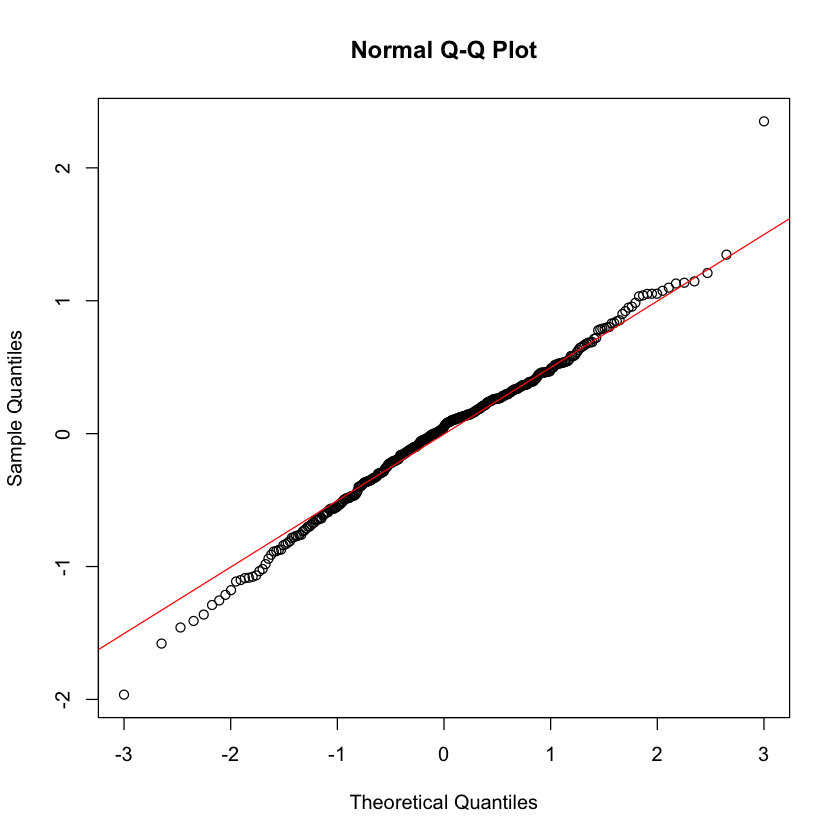


Call:
ivreg(formula = neutral_score ~ neutral_count + category + views | 
    total_comment + total_comment + category + views, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96415 -0.34094  0.05202  0.33413  2.35006 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.08008    0.46720   0.171    0.864    
neutral_count      1.13038    0.06477  17.454   <2e-16 ***
categoryPolitical -0.02218    0.06419  -0.346    0.730    
views              0.07225    0.05962   1.212    0.226    

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 367  2088.263  <2e-16 ***
Wu-Hausman         1 366     0.035   0.852    
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5499 on 367 degrees of freedom
Multiple R-Squared: 0.8125,	Adjusted R-squared: 0.811 
Wald test: 513.3 on 3 and 367 DF,  p-value: < 2.2e-16 



	Jarque Bera Test

data:  residuals(second_stage_neu)
X-squared = 14.863, df = 2, p-value = 0.0005922


	RESET test

data:  second_stage_neu
RESET = 0.45507, df1 = 2, df2 = 365, p-value = 0.6348


	studentized Breusch-Pagan test

data:  second_stage_neu
BP = 0.47982, df = 2, p-value = 0.7867



ERROR: [1m[33mError[39m in `geom_point()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mi[39m Error occurred in the 1st layer.
[1mCaused by error:[22m
[33m![39m object 'neu_score' not found


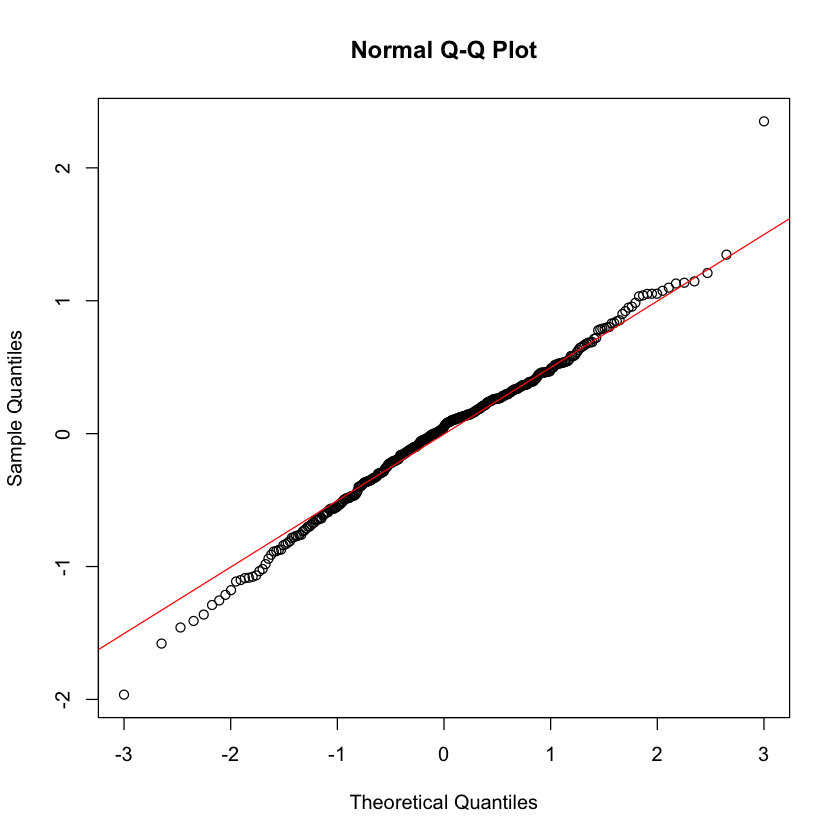

In [42]:
first_stage_neu <- lm(neutral_count ~ total_comment + category + views, data = data)
print(resettest(first_stage_neu))
normal_test_neu <- jarque.bera.test(residuals(first_stage_neu))
print(normal_test_neu)

bp_test_neu <- bptest(first_stage_neu, ~ fitted(first_stage_neu) + I(fitted(first_stage_neu)^2))
print(bp_test_neu)

summary(first_stage_neu, diagnostics = TRUE)

# Fit the mediation model for Neutral Count
med_model_neu <- lm(neutral_count ~ total_comment + category + views, data = data)

# Fit the outcome model for Neutral Score
out_model_neu <- lm(neutral_score ~ neutral_count + category + views + total_comment, data = data)
summary(out_model_neu)

# Perform mediation analysis for Neutral variables
med_analysis_neu <- mediate(med_model_neu, out_model_neu, treat = "total_comment", mediator = "neutral_count", sims=1000, robustSE = TRUE)
summary(med_analysis_neu)

# Normality test for Neutral Count model
normal_test_neu <- jarque.bera.test(residuals(med_model_neu))
print(normal_test_neu)

normal_test_neu_out <- jarque.bera.test(residuals(out_model_neu))
print(normal_test_neu_out)

# Second stage regression for Neutral Score
second_stage_neu <- ivreg(neutral_score ~ neutral_count + category + views | total_comment + total_comment + category + views, data = data)

fitted_values_neu <- fitted(second_stage_neu)
residuals_values_neu <- residuals(second_stage_neu)
qqnorm(residuals_values_neu)
qqline(residuals_values_neu, col = "red")

# Q-Q Plot for Neutral Score
qqnorm(residuals_values_neu)
qqline(residuals_values_neu, col = "red")

summary(second_stage_neu, diagnostics = TRUE)
normal_test_neu_second_stage <- jarque.bera.test(residuals(second_stage_neu))
print(normal_test_neu_second_stage)
print(resettest(second_stage_neu))

bp_test_neu_second_stage <- bptest(second_stage_neu, ~ fitted(second_stage_neu) + I(fitted(second_stage_neu)^2))
print(bp_test_neu_second_stage)

# Plot for Neutral Comments
H2_reg_neu_comment <- ggplot(data, aes(x = predict(first_stage_neu), y = predict(second_stage_neu), color = category, group = category)) +
  geom_point(aes(y = neu_score), alpha = 0.5) +  # Scatter plot points
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE, linewidth = 0.5, level = 0.95) +  # Regression lines with confidence intervals
  labs(title = "2 Stage Least Squares for Neutral Comment Likes",
       x = "Neutral Count Prediction",
       y = "Neutral Score") +
  theme_minimal()

# Save the plot for Neutral Comments
save_plot(H2_reg_neu_comment)

In [ ]:
second_stage <- ivreg(pos_score ~ pos_count + category + views | total_comment + category + views, data = data)

summary(second_stage, diagnostics = TRUE)

normal_test <- jarque.bera.test(residuals(second_stage))
print(normal_test)

print(resettest(second_stage))

bp_test <- bptest(second_stage, ~ fitted(second_stage) + I(fitted(second_stage)^2))
print(bp_test)

H2_reg_pos_comment <- ggplot(data, aes(x = predict(first_stage), y = predict(second_stage), color = category, group = category)) +
  geom_point(aes(y = pos_score), alpha = 0.5) +
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE, linewidth = 0.5, level = 0.95) +
  labs(x = "Positive Count Prediction",
       y = "Positive Score") +
  theme_minimal()

save_plot(H2_reg_pos_comment)


In [ ]:
# First-stage regression: Replace neg_count with neutral_count
first_stage <- lm(neutral_count ~ total_comment + category, data = data)
data$neutral_count_pred <- predict(first_stage)  # Replace neg_count_pred with neutral_count_pred

# Second-stage regression: Replace neg_score with neutral_score and neg_count_pred with neutral_count_pred
second_stage <- lm(neutral_score ~ neutral_count_pred + category + views, data = data)
summary(second_stage)

# Residuals and diagnostic tests
residuals <- second_stage$residuals
shapiro_test <- shapiro.test(residuals)
print(shapiro_test)
print(resettest(second_stage))
hausman_test <- phtest(first_stage, second_stage)
print(hausman_test)

# Plot diagnostics for the second stage
plot(second_stage)

# Breusch-Pagan test for heteroscedasticity
bp_test <- bptest(second_stage, ~ fitted(second_stage) + I(fitted(second_stage)^2))
print(bp_test)

# Predicted values from the second-stage regression
data$s2_neutral_predicted_values <- predict(second_stage)  # Replace s2_neg_predicted_values with s2_neutral_predicted_values

# Plot for Neutral Count and Score: Replace 'Negative' labels with 'Neutral'
H2_reg_neutral_comment <- ggplot(data, aes(x = neutral_count_pred, y = s2_neutral_predicted_values, color = category, group = category)) +
  geom_point(aes(y = neutral_score), alpha = 0.5) +  # Scatter plot points (neg_score to neutral_score)
  geom_smooth(method = "lm", se = TRUE, fullrange = TRUE, linewidth = 0.5, level = 0.95) +  # Regression lines with confidence intervals
  labs(title = "2 Stage Least Squares for Neutral Comment Likes",  # Update title
       x = "Neutral Count Prediction",  # Update X-axis label
       y = "Neutral Score") +  # Update Y-axis label
  theme_minimal()

# Save the plot with the new name
save_plot(H2_reg_neutral_comment)


# Diagram generations

In [ ]:
neg_like_dist_cat <- ggplot(data, aes(x = neg_score, color = category)) +
  geom_histogram(aes(y=stat(density)),fill = "skyblue", color = "black",bins = 50) +
  geom_density(alpha = 0.5) +
  labs(
    title = "Histogram of likes received by negative comment",
    x = "Amount of likes",
    y = "Probability density"
  ) +
  scale_x_log10(breaks = breaks_log10,
                labels = trans_format(log10, math_format(10^.x)))

neg_like_dist <- ggplot(data, aes(x = neg_score)) +
  geom_histogram(aes(y=stat(density)),fill = "skyblue", color = "black",bins = 50) +
  geom_density(alpha = 0.5) +
  labs(
    title = "Histogram of likes received by negative comment",
    x = "Amount of likes",
    y = "Probability density") +
  scale_x_log10(breaks = breaks_log10,
                labels = trans_format(log10, math_format(10^.x)))


neg_like_ecdf <- ggplot(data, aes(x = neg_score, color = category)) +
  stat_ecdf(geom = "step") +
  labs(title = "ECDF of likes recevied by negative comment",
       x = "Amount of likes(Log scale)",
       y = "ECDF") +
  theme_minimal()+
  scale_x_log10(breaks = breaks_log10,
                labels = trans_format(log10, math_format(10^.x)))

save_plot(neg_like_dist)
save_plot(neg_like_dist_cat)
save_plot(neg_like_ecdf)

In [ ]:
model <- lm(neg_score ~ category + views, data = data)  
summary(model) 

H2_reg_neg_views <- ggplot(data, aes(x = views, y = neg_score, color = factor(category))) +  
    geom_point(alpha = 0.1)+
    geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5, level = 0.95) +
    labs( x = "total views(log scaled)",  
        y = "likes recevied by negative comments(log scaled)",  
        color = "Cateogory of news") + 
    theme_minimal() +
save_plot(H2_reg_neg_views)

In [ ]:
model <- lm(pos_score ~ category + views, data = data)  
summary(model) 

H2_reg_pos_view <- ggplot(data, aes(x = views, y = pos_score, color = factor(category))) +  
    geom_point(alpha = 0.1)+
    geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5, level = 0.95) +
    labs( x = "total views(log scaled)",  
        y = "likes recevied by positive comments(log scaled)",  
        color = "Cateogory of news") + 
        theme_minimal() +

save_plot(H2_reg_pos_view)

In [ ]:
model <- lm(neutral_score ~ category + views, data = data)  
summary(model) 

H2_reg_neu_views <- ggplot(data, aes(x = views, y = neutral_score, color = factor(category))) +  
    geom_point(alpha = 0.1)+
    geom_smooth(method = "lm", se = TRUE, fullrange = TRUE,linewidth = 0.5, level = 0.95) +
    labs( x = "total views(log scaled)",  
        y = "likes recevied by neutral comments(log scaled)",  
        color = "Cateogory of news") + 
        theme_minimal() +
save_plot(H2_reg_neu_views)

In [ ]:
view_comm <- lm(neg_count ~ views,data = data)
summary(view_comm)